In [ ]:
# note
__[This](https://github.com/BVLC/caffe/blob/master/examples/02-fine-tuning.ipynb) is the original notebook where the following code was adopted from__

# some set up

### import the required libraries

In [1]:
caffe_root = '/home/jackcen/Desktop/caffe/'
data_root = '/home/jackcen/Desktop/cs229/data/'

In [2]:
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

caffe.set_device(0)
caffe.set_mode_gpu()

import numpy as np
from pylab import *
%matplotlib inline
import tempfile

### load pretrained weights, labels, and mean image

In [3]:
# Download pretrained model for VGG-16
import os
os.chdir(caffe_root)  # from caffe root
!scripts/download_model_from_gist.sh 211839e770f7b538e2d8 models/vgg_16
!scripts/download_model_binary.py /home/jackcen/Desktop/caffe/models/vgg_16/211839e770f7b538e2d8


models/vgg_16/211839e770f7b538e2d8 already exists! Please make sure you're not overwriting anything important!
ERROR: '---' is not in list
usage: download_model_binary.py [-h] dirname
download_model_binary.py: error: argument dirname: Must be valid Caffe model directory with a correct readme.md


In [3]:
# Define weights, the path to the Vgg-16 pretrained weights we just downloaded, and make sure it exists.
import os
weights = caffe_root + 'models/vgg_16/VGG_ILSVRC_16_layers.caffemodel'
assert os.path.exists(weights)

### load StateFarm data

In [4]:
# download StateFarm data
# Make sure you have read the README file under data directory
import os
os.chdir(data_root)
if os.path.isdir('train'):
    print "dataset is already exists"
else:
    !bash get_datasets.sh

dataset is already exists


In [5]:
# define train and valid sets
import pandas as pd

print("Reading CSV")
labels = pd.read_csv(data_root+'driver_imgs_list.csv')[['subject', 'img', 'classname']]
labels['img'] = labels.apply(lambda row: data_root+'train_resize/'+row.classname+'/'+row.img, 1)
labels['classname'] = labels['classname'].map(lambda l: l[1])
labels = labels.reindex(np.random.permutation(labels.index))

# select a driver (say p002)
print("Splitting Data")
isP001 = labels["subject"] == "p002"
isP002 = labels["subject"] == "p012"
isP003 = labels["subject"] == "p014"


test = labels[isP001 | isP002 | isP003][['img', 'classname']]
train = labels[~isP001 & ~isP002 & ~isP003][['img', 'classname']]

# write the csv
print("Writing CSV")
test.to_csv(data_root+'valid.txt', sep=' ', header=False, index=False)
train.to_csv(data_root+'train.txt', sep=' ', header=False, index=False)
labels = None

NUM_STATEFARM_LABELS = 10
kaggle_labels = [
    'c0: safe driving',
    'c1: texting - right',
    'c2: talking on the phone - right',
    'c3: texting - left',
    'c4: talking on the phone - left',
    'c5: operating the radio',
    'c6: drinking',
    'c7: reaching behind',
    'c8: hair and makeup',
    'c9: talking to passenger'
]

Reading CSV
Splitting Data
Writing CSV


# some definitions

### defining vgg-16 net
vgg16net, a function which initializes the Vgg-16 architecture, taking arguments specifying the data and number of output classes.

In [6]:
from caffe import layers as L
from caffe import params as P

weight_param = dict(lr_mult=1, decay_mult=1)
bias_param   = dict(lr_mult=2, decay_mult=0)
learned_param = [weight_param, bias_param]

frozen_param = [dict(lr_mult=0)] * 2

def conv_relu(bottom, ks, nout, pad=0, group=1,
              param=learned_param,
              weight_filler=dict(type='xavier'),
              bias_filler=dict(type='constant', value=0.0)):
    conv = L.Convolution(bottom, kernel_size=ks,
                         num_output=nout, pad=pad, weight_filler=weight_filler,
                         bias_filler=bias_filler)
    return conv, L.ReLU(conv, in_place=True)

def fc_relu(bottom, nout, param=learned_param,
            weight_filler=dict(type='xavier'),
            bias_filler=dict(type='constant', value=0.1)):
    fc = L.InnerProduct(bottom, num_output=nout,
                        weight_filler=weight_filler,
                        bias_filler=bias_filler)
    return fc, L.ReLU(fc, in_place=True)

def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)


def vgg16net(data=None, label=None, train=True, num_classes=1000,
             classifier_name='fc8', learn_all=False):
    """Returns a NetSpec specifying CaffeNet, following the original proto text
       specification (./models/bvlc_reference_caffenet/train_val.prototxt)."""
    n = caffe.NetSpec()
    n.data = data
    param = learned_param if learn_all else frozen_param
    n.conv1_1, n.relu1_1 = conv_relu(n.data, ks=3, nout=64, pad=1, param=param)
    n.conv1_2, n.relu1_2 = conv_relu(n.relu1_1, ks=3, nout=64, pad=1, param=param)
    n.pool1 = max_pool(n.relu1_2, ks=2, stride=2)
    n.conv2_1, n.relu2_1 = conv_relu(n.pool1, ks=3, nout=128, pad=1, param=param)
    n.conv2_2, n.relu2_2 = conv_relu(n.relu2_1, ks=3, nout=128, pad=1, param=param)
    n.pool2 = max_pool(n.relu2_2, ks=2, stride=2)
    n.conv3_1, n.relu3_1 = conv_relu(n.pool2, ks=3, nout=256, pad=1, param=param)
    n.conv3_2, n.relu3_2 = conv_relu(n.relu3_1, ks=3, nout=256, pad=1, param=param)
    n.conv3_3, n.relu3_3 = conv_relu(n.relu3_2, ks=3, nout=256, pad=1, param=param)
    n.pool3 = max_pool(n.relu3_3, ks=2, stride=2)
    n.conv4_1, n.relu4_1 = conv_relu(n.pool3, ks=3, nout=512, pad=1, param=param)
    n.conv4_2, n.relu4_2 = conv_relu(n.relu4_1, ks=3, nout=512, pad=1, param=param)
    n.conv4_3, n.relu4_3 = conv_relu(n.relu4_2, ks=3, nout=512, pad=1, param=param)
    n.pool4 = max_pool(n.relu4_3, ks=2, stride=2)
    n.conv5_1, n.relu5_1 = conv_relu(n.pool4, ks=3, nout=512, pad=1, param=param)
    n.conv5_2, n.relu5_2 = conv_relu(n.relu5_1, ks=3, nout=512, pad=1, param=param)
    n.conv5_3, n.relu5_3 = conv_relu(n.relu5_2, ks=3, nout=512, pad=1, param=param)
    n.pool5 = max_pool(n.relu5_3, ks=2, stride=2)
    n.fc6, n.relu6 = fc_relu(n.pool5, nout=4096, param=param)
    if train:
        n.drop6 = fc7input = L.Dropout(n.relu6, dropout_param=dict(dropout_ratio=0.5), in_place=True)
    else:
        fc7input = n.relu6

    n.fc7, n.relu7 = fc_relu(fc7input, nout=4096, param=param)
    if train:
        n.drop7 = fc8input = L.Dropout(n.relu7, dropout_param=dict(dropout_ratio=0.5), in_place=True)
    else:
        fc8input = n.relu7

    # always learn fc8 (param=learned_param)
    fc8 = L.InnerProduct(fc8input, num_output=num_classes, weight_filler=dict(type='xavier'), bias_filler=dict(type='constant', value=0.1), param=learned_param)
    # give fc8 the name specified by argument `classifier_name`
    n.__setattr__(classifier_name, fc8)
    if not train:
        n.probs = L.Softmax(fc8)
    if label is not None:
        n.label = label
        n.loss = L.SoftmaxWithLoss(fc8, n.label)
        n.acc = L.Accuracy(fc8, n.label)
    # write the net to a temporary file and return its filename
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(n.to_proto()))
        return f.name 
    

### define solver
function solver to create our Caffe solvers, which are used to train the network (learn its weights)

In [7]:
from caffe.proto import caffe_pb2

def solver(train_net_path, test_net_path=None, base_lr=0.0001):
    s = caffe_pb2.SolverParameter()

    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    if test_net_path is not None:
        s.test_net.append(test_net_path)
        s.test_interval = 1000  # Test after every 1000 training iterations.
        s.test_iter.append(50) # Test on 100 batches each time we test.

    # The number of iterations over which to average the gradient.
    # Effectively boosts the training batch size by the given factor, without
    # affecting memory utilization.
    s.iter_size = 1
    
    s.max_iter = 100000     # # of times to update the net (training iterations)
    
    # Solve using the stochastic gradient descent (SGD) algorithm.
    # Other choices include 'Adam' and 'RMSProp'.
    s.type = 'SGD'

    # Set the initial learning rate for SGD.
    s.base_lr = base_lr

    # Set `lr_policy` to define how the learning rate changes during training.
    # Here, we 'step' the learning rate by multiplying it by a factor `gamma`
    # every `stepsize` iterations.
    s.lr_policy = 'step'
    s.gamma = 0.1
    s.stepsize = 20000

    # Set other SGD hyperparameters. Setting a non-zero `momentum` takes a
    # weighted average of the current gradient and previous gradients to make
    # learning more stable. L2 weight decay regularizes learning, to help prevent
    # the model from overfitting.
    s.momentum = 0.9
    s.weight_decay = 5e-4

    # Display the current training loss and accuracy every 1000 iterations.
    s.display = 1000

    # Snapshots are files used to store networks we've trained.  Here, we'll
    # snapshot every 10K iterations -- ten times during training.
    s.snapshot = 10000
    s.snapshot_prefix = data_root + 'models'
    
    # Train on the GPU.  Using the CPU to train large networks is very slow.
    s.solver_mode = caffe_pb2.SolverParameter.GPU
    
    # Write the solver to a temporary file and return its filename.
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(s))
        return f.name

### define kaggle_net
function kaggle_net which calls caffenet on data from the StateFarm dataset.

The new network will also have the CaffeNet architecture, with differences in the input and output:

* the input is the Kaggle StateFarm data we downloaded, provided by an ImageData layer
* the output is a distribution over 10 classes rather than the original 1000 ImageNet classes
* the classification layer is renamed from fc8 to fc8_kaggle to tell Caffe not to load the original classifier (fc8) weights from the ImageNet-pretrained model

In [8]:
def kaggle_net(train=True, learn_all=False, batch_size=12):
    source = data_root + 'train.txt' if train else 'valid.txt'
    
    transform_param = dict(mirror=train, crop_size=224, mean_value=[104.00698793,116.66876762,122.67891434])
       #mean_file=caffe_root + 'data/ilsvrc12/imagenet_mean.binaryproto')

    kaggle_data, kaggle_label = L.ImageData(
        transform_param=transform_param, source=source,
        batch_size=batch_size, new_height=224, new_width=224, ntop=2)
    
    return vgg16net(data=kaggle_data, label=kaggle_label, train=train,
                    num_classes=NUM_STATEFARM_LABELS,
                    classifier_name='fc8_kaggle',
                    learn_all=learn_all)

### define run_solver
run_solvers, a function that takes a list of solvers and steps each one in a round robin manner, recording the accuracy and loss values each iteration. At the end, the learned weights are saved to a file.

In [12]:
def eval_kaggle_net(weights, test_iters=200):
    test_net = caffe.Net(kaggle_net(train=False), weights, caffe.TEST)
    accuracy = 0
    loss = 0
    for it in xrange(test_iters):
        accuracy += test_net.forward()['acc']
        loss += test_net.forward()['loss']
    accuracy /= test_iters
    loss /= test_iters
    return test_net, loss, accuracy

In [9]:
def run_solvers(niter, solvers, disp_interval=500, test_interval=1000):
    """
    Run solvers for niter iterations,
    returning the loss and accuracy recorded each iteration.
    'solvers' is a list of (name, solver) tuples.
    """
    blobs = ('loss', 'acc')
    loss, acc = ({name: np.zeros(niter) for name, _ in solvers}
                 for _ in blobs)
        
    for it in range(niter):
        for name, s in solvers:
            s.step(1)  # run a single SGD step in Caffe
            loss[name][it], acc[name][it] = (s.net.blobs[b].data.copy()
                                             for b in blobs)
        if it % disp_interval == 0 or it + 1 == niter:
            loss_disp = '; '.join('%s: loss=%.3f, acc=%2d%%' %
                                  (n, loss[n][it], 100*acc[n][it])
                                  for n, _ in solvers)
            print '%3d) %s' % (it, loss_disp)  


        if it % test_interval == 0 or it + 1 == niter:

            # Save the learned weights from both nets.
            weight_dir = tempfile.mkdtemp()
            weights = {}
            for name, s in solvers:
                filename = 'weights.%s.caffemodel' % name
                weights[name] = os.path.join(weight_dir, filename)
                s.net.save(weights[name])

            test_net, loss, accuracy = eval_kaggle_net(weights)
            print 'Validation loss, accuracy, trained from ImageNet initialization: %f, %3.1f%%' % (loss, 100*accuracy)
    

    # Save the learned weights from both nets.
    weight_dir = tempfile.mkdtemp()
    weights = {}
    for name, s in solvers:
        filename = 'weights.%s.caffemodel' % name
        weights[name] = os.path.join(weight_dir, filename)
        s.net.save(weights[name])
        
    return loss, acc, weights

# train the model

kaggle solver: train net initialized to the ImageNet-pretrained weights (this is done by the call to the copy_from method)

In [10]:
import time
start_time = time.time()
niter = 1500  # number of iterations to train

# Reset kaggle_solver as before.
kaggle_solver_filename = solver(kaggle_net())
#kaggle_solver = caffe.get_solver(kaggle_solver_filename)
kaggle_solver = caffe.SGDSolver(kaggle_solver_filename)
kaggle_solver.net.copy_from(weights)

print 'Running solvers for %d iterations...' % niter
solvers = [('pretrained', kaggle_solver)]
loss, acc, weights = run_solvers(niter, solvers)
print 'Done.'

train_loss = loss['pretrained']
train_acc = acc['pretrained']
kaggle_weights = weights['pretrained']

# Delete solvers to save memory.
del kaggle_solver, solvers

print "Finished training the model in %f s" % (time.time() - start_time)

Running solvers for 3300 iterations...
  0) pretrained: loss=2.671, acc= 8%
100) pretrained: loss=2.285, acc= 8%
200) pretrained: loss=2.255, acc=25%
300) pretrained: loss=2.006, acc=33%
400) pretrained: loss=2.124, acc=25%
500) pretrained: loss=1.788, acc=41%
600) pretrained: loss=1.432, acc=41%
700) pretrained: loss=1.341, acc=58%
800) pretrained: loss=1.284, acc=50%
900) pretrained: loss=0.967, acc=75%
1000) pretrained: loss=1.156, acc=41%
1100) pretrained: loss=0.780, acc=83%
1200) pretrained: loss=0.787, acc=75%
1300) pretrained: loss=0.682, acc=83%
1400) pretrained: loss=0.244, acc=100%
1500) pretrained: loss=0.758, acc=75%
1600) pretrained: loss=0.405, acc=83%
1700) pretrained: loss=0.642, acc=91%
1800) pretrained: loss=0.251, acc=91%
1900) pretrained: loss=0.280, acc=91%
2000) pretrained: loss=0.282, acc=91%
2100) pretrained: loss=0.288, acc=91%
2200) pretrained: loss=0.676, acc=75%
2300) pretrained: loss=0.502, acc=91%
2400) pretrained: loss=0.187, acc=100%
2500) pretrained: l

### visualize the learning process

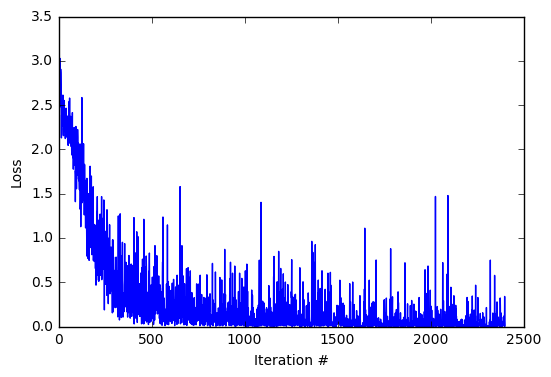

In [12]:
plot(np.vstack([train_loss]).T)
xlabel('Iteration #')
ylabel('Loss')

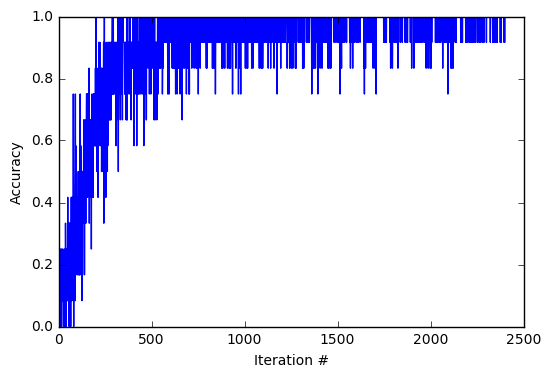

In [13]:
plot(np.vstack([train_acc]).T)
xlabel('Iteration #')
ylabel('Accuracy')

In [12]:
def eval_kaggle_net(weights, test_iters=200):
    test_net = caffe.Net(kaggle_net(train=False), weights, caffe.TEST)
    accuracy = 0
    loss = 0
    for it in xrange(test_iters):
        accuracy += test_net.forward()['acc']
        loss += test_net.forward()['loss']
    accuracy /= test_iters
    loss /= test_iters
    return test_net, loss, accuracy

In [13]:
test_net, loss, accuracy = eval_kaggle_net(kaggle_weights)
print 'Validation loss, accuracy, trained from ImageNet initialization: %f, %3.1f%%' % (loss, 100*accuracy)
del test_net

Validation loss, accuracy, trained from ImageNet initialization: 0.829384, 69.0%


# Extract Probabilities

### define helper functions

In [13]:
def initialize_transformer(net):
    mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
    mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values

    # create transformer for the input called 'data'
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

    transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
    transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
    transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
    transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR
    
    return transformer

def preprocess_batch(images, transformer):
    transformed_images = map(
        lambda image: transformer.preprocess('data', caffe.io.load_image(image)),
        images
    )
    return transformed_images

def process_batch(net, images):
    net.blobs['data'].data[...] = images
    probs = net.forward(start='conv1_1')['probs']
    return probs

def process_image(net, image):
    net.blobs['data'].data[0, ...] = image
    p = net.forward(start='conv1_1')['probs'][0]
    return p

def write_to_file(f_name, probs, images_name):
    with open(data_root + f_name, "a") as f:
        for i in xrange(len(probs)):
            f.write(images_name[i][len(data_root)+5:])
            for p in probs[i]:
                f.write(",%f" % p)
            f.write('\n')
            

### extract probabilities for each class

In [14]:
def extract_probabilities(net, image_set, batch_size=12, out_file='submission.csv', display_interval=100):
    start_time = time.time()
    with open(data_root + out_file, "a") as f:
        f.write("img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9\n")
    
    transformer = initialize_transformer(net)
    in_batch_size = (len(image_set)/batch_size)*batch_size    
    
    for s in range(0, in_batch_size, batch_size):
        images = image_set[s:s+batch_size]
        preprocessed_images = preprocess_batch(images, transformer)
        probs = process_batch(net, preprocessed_images)
        probs[probs < 0.00001] = 0
        write_to_file(out_file, probs, images)
        if (s / batch_size) % display_interval == 0:
            print "Processed %i images in %f sec" % (s, time.time() - start_time)
        
    # for some reason reshaping the image data layer causes the kernel to crash    
    left = image_set[in_batch_size:]
    probs = []
    for image in left:
        preprocessed_image = transformer.preprocess('data', caffe.io.load_image(image))
        probs_tmp = process_image(net, preprocessed_image)
        probs_tmp[probs_tmp < 0.00001] = 0
        probs.append(probs_tmp)
    write_to_file(out_file, probs, left)
    
    print "Finished extracting probabilities in %f sec" % (time.time() - start_time)

In [15]:
test_images = map(lambda name: data_root+'test/'+name, os.listdir(data_root+'test'))
test_net = caffe.Net(kaggle_net(train=False), kaggle_weights, caffe.TEST)

In [16]:
extract_probabilities(test_net, test_images)

Processed 0 images in 0.991250 sec
Processed 120 images in 5.799481 sec
Processed 240 images in 10.582510 sec
Processed 360 images in 15.403478 sec
Processed 480 images in 20.271965 sec
Processed 600 images in 25.032500 sec
Processed 720 images in 29.897410 sec
Processed 840 images in 35.395636 sec
Processed 960 images in 40.280158 sec
Processed 1080 images in 45.042567 sec
Processed 1200 images in 49.936036 sec
Processed 1320 images in 54.664080 sec
Processed 1440 images in 59.567565 sec
Processed 1560 images in 64.406102 sec
Processed 1680 images in 69.822931 sec
Processed 1800 images in 74.752408 sec
Processed 1920 images in 79.533424 sec
Processed 2040 images in 84.277883 sec
Processed 2160 images in 89.203566 sec
Processed 2280 images in 93.886744 sec
Processed 2400 images in 98.683980 sec
Processed 2520 images in 104.033411 sec
Processed 2640 images in 108.802644 sec
Processed 2760 images in 113.685490 sec
Processed 2880 images in 118.592186 sec
Processed 3000 images in 123.36450

In [70]:

# Results ensemble

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.6f' % x)

vgg1 = pd.read_csv('/Users/kaiqi/Desktop/vgg.csv')
caffenet = pd.read_csv('/Users/kaiqi/Desktop/caffenet.csv')
vgg2 = pd.read_csv('/Users/kaiqi/Desktop/vgg0.49.csv')
vgg3 = pd.read_csv('/Users/kaiqi/Desktop/vgg0.55.csv')
vgg4 = pd.read_csv('/Users/kaiqi/Desktop/vgg0.48.csv')


ensemble = pd.concat((vgg1,vgg2,vgg3,vgg4,caffenet))
gb = ensemble.groupby(ensemble.index)
mean = gb.mean()
mean['img'] = vgg['img']
mean = mean[['img','c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']]

mean.to_csv('/Users/kaiqi/Desktop/vgg4avgCaffenet.csv', float_format='%.6f', sep=',', index=False)

